In [1]:
from multiprocessing import Pool
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import pickle
import h5py
import gzip
import time
import csv
import os

In [2]:
model_folder_name = '13_cccfff'
batch_size = 10000

main_path = '/fhgfs/users/jbehnken/01_Data/04_Models'
meta_loading_folder = os.path.join(main_path, model_folder_name)
meta_loading_path = os.path.join(main_path, model_folder_name, model_folder_name.split('_')[-1] + '.meta')

mc_data_path = '/fhgfs/users/jbehnken/01_Data/01_MC_Data' # Path to preprocessed data
num_files = 1000 # Number of files to load - 1 file = 1000 events

In [3]:
# Load pickled data and split it into pictures and labels
def load_data(file):
    with gzip.open(mc_data_path+'/'+file, 'rb') as f:
        data_dict = pickle.load(f)
    pic = data_dict['Image']
    lab = data_dict['Label']
    return (pic, lab)

# Randomizing the files to load
loading_files = os.listdir(mc_data_path)
np.random.shuffle(loading_files)

# Pool-load pickled data and split it into pictures and labels (list)
p = Pool()
data = p.map(load_data, loading_files[-num_files:])
pics, labs = zip(*data)

# Concatenate the data to a single np.array
evaluation_dataset = np.concatenate(pics)
evaluation_labels = np.concatenate(labs)
del pics, labs
evaluation_dataset.shape

(1000000, 46, 45, 1)

In [4]:
def batchYielder():
    max_steps = int(evaluation_dataset.shape[0]/(batch_size))
    for i in range(max_steps):
        yield evaluation_dataset[i*batch_size:(i+1)*batch_size]

In [5]:
gpu_config = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.2)
session_conf = tf.ConfigProto(gpu_options=gpu_config, intra_op_parallelism_threads=18, inter_op_parallelism_threads=18)


with tf.Session(config=session_conf) as sess:
    saver = tf.train.import_meta_graph(meta_loading_path)    
    saver.restore(sess, tf.train.latest_checkpoint(meta_loading_folder))
    
    graph = tf.get_default_graph() 
    try:
        conv2d_1_weights = graph.get_tensor_by_name("conv2d_1/W:0")
        conv2d_1_biases = graph.get_tensor_by_name("conv2d_1/B:0")
        print('Conv2d_1', conv2d_1_weights.shape)
    except: pass
    
    try:
        conv2d_2_weights = graph.get_tensor_by_name("conv2d_2/W:0")
        conv2d_2_biases = graph.get_tensor_by_name("conv2d_2/B:0")
        print('Conv2d_2', conv2d_2_weights.shape)
    except: pass
    
    try:
        conv2d_3_weights = graph.get_tensor_by_name("conv2d_3/W:0")
        conv2d_3_biases = graph.get_tensor_by_name("conv2d_3/B:0")
        print('Conv2d_3', conv2d_3_weights.shape)
    except: pass
    
    try:
        conv2d_4_weights = graph.get_tensor_by_name("conv2d_4/W:0")
        conv2d_4_biases = graph.get_tensor_by_name("conv2d_4/B:0")
        print('Conv2d_4', conv2d_4_weights.shape)
    except: pass
    
    try:
        conv2d_5_weights = graph.get_tensor_by_name("conv2d_5/W:0")
        conv2d_5_biases = graph.get_tensor_by_name("conv2d_5/B:0")
        print('Conv2d_5', conv2d_5_weights.shape)
    except: pass
    
    try:
        fc_1_weights = graph.get_tensor_by_name("fc_1/W:0")
        fc_1_biases = graph.get_tensor_by_name("fc_1/B:0")
        print('Fc_1', fc_1_weights.shape)
    except: pass
    
    try:
        fc_2_weights = graph.get_tensor_by_name("fc_2/W:0")
        fc_2_biases = graph.get_tensor_by_name("fc_2/B:0")
        print('Fc_2', fc_2_weights.shape)
    except: pass
    
    try:
        fc_3_weights = graph.get_tensor_by_name("fc_3/W:0")
        fc_3_biases = graph.get_tensor_by_name("fc_3/B:0")
        print('Fc_3', fc_3_weights.shape)
    except: pass
    print("Model restored.")
    
    
    #tf_prediction_dataset = tf.constant(images, name='prediction_data')
    tf_evaluation_dataset = tf.placeholder(tf.float32, shape=(batch_size, 46, 45, 1), name='Evaluation_data')        
    
    preds_1 = []
    preds_2 = []
    #sess.run(tf.global_variables_initializer())
    
    name = model_folder_name.split('_')[-1]
    for images in batchYielder():
        feed_dict = {tf_evaluation_dataset : images}
        
        if name=='cff':
            with tf.name_scope('prediction_cff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_evaluation_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')        
                shape = pool_1.get_shape().as_list()
                reshape = tf.reshape(pool_1, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_cff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_cff, feed_dict=feed_dict)
            
        elif name=='ccff':
            with tf.name_scope('prediction_ccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_evaluation_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_2.get_shape().as_list()
                reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_ccff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_ccff, feed_dict=feed_dict)
        
        elif name=='cccff':
            with tf.name_scope('prediction_cccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_evaluation_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_3 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_2, conv2d_3_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_3_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_3.get_shape().as_list()
                reshape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_cccff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_cccff, feed_dict=feed_dict)
        
        elif name=='cccfff':
            with tf.name_scope('prediction_cccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_evaluation_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_3 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_2, conv2d_3_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_3_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_3.get_shape().as_list()
                reshape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                hidden = tf.nn.relu(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
                prediction_cccfff = tf.nn.softmax(tf.matmul(hidden, fc_3_weights) + fc_3_biases)
            pred = sess.run(prediction_cccfff, feed_dict=feed_dict)
        
        else:
            break        
        
        preds_1.extend(pred[:,0])
        preds_2.extend(pred[:,1])
        
prediction = np.array(list(zip(preds_1, preds_2)))
prediction.shape

Conv2d_1 (5, 5, 1, 9)
Conv2d_2 (5, 5, 9, 18)
Conv2d_3 (5, 5, 18, 36)
Fc_1 (1296, 35)
Fc_2 (35, 35)
Fc_3 (35, 2)
Model restored.


(1000000, 2)

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [7]:
accuracy_score(np.argmax(evaluation_labels, axis=1), np.argmax(prediction, axis=1))

0.91014399999999995

In [8]:
auc = roc_auc_score(evaluation_labels, prediction)
auc

0.92763619091603033

Accuracy: 0.91124000000000005

Auc: 0.9285115862726846

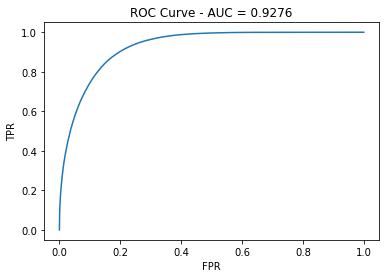

In [9]:
fpr, tpr, tresh = roc_curve(np.argmax(evaluation_labels, axis=1), prediction[:,1])

plt.plot(fpr, tpr)
plt.title('ROC Curve - AUC = {:.4f}'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

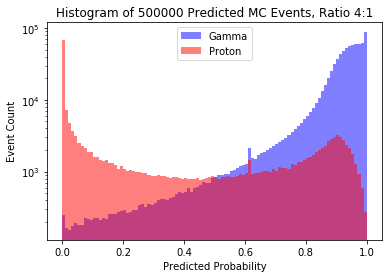

In [10]:
plt.hist(prediction[:,1][np.array(np.argmax(evaluation_labels, axis=1),dtype=bool)], color='b', alpha=0.5, bins=100, label='Gamma')
plt.hist(prediction[:,1][~np.array(np.argmax(evaluation_labels, axis=1),dtype=bool)], color='r', alpha=0.5, bins=100, label='Proton')
plt.yscale('log')
plt.title('Histogram of 500000 Predicted MC Events, Ratio 4:1')
plt.xlabel('Predicted Probability')
plt.ylabel('Event Count')
plt.legend()
plt.show()